# Lesson 1: VGG16 From Scratch

In [1]:
import json

import numpy as np
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Dropout, Dense, Flatten, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing import image
from keras import backend
from matplotlib import pyplot as plt
from keras.optimizers import Adam

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
def plots(ims, figsize=(12, 6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0, 2, 3, 1))
    f = plt.figure(figsize=figsize)
    
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims) // rows, i + 1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [3]:
data_path = '/home/ubuntu/nbs/data/'

In [4]:
FILES_PATH = 'https://files.fast.ai/models/'
CLASS_FILE='imagenet_class_index.json'
fpath = get_file(CLASS_FILE, FILES_PATH + CLASS_FILE, cache_subdir='models')

In [5]:
with open(fpath) as f:
    class_dict = json.load(f)

# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

## Model creation

Define the basic pieces of the VGG architecture: one type of convolutional block and one type of fully connected "dense" block. Convolutional block definition:

In [6]:
def ConvBlock(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

Fully-connected definition:

In [7]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

Model creators subtracted the mean from each RGB value. Also, the values are provided as BGR for some reason...

In [8]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1]

In [9]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3, 224, 224), output_shape=(3, 224, 224)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
    
    model.add(Flatten())
    
    FCBlock(model)
    FCBlock(model)
    
    model.add(Dense(1000, activation='softmax'))
    
    return model

def finetune(model, batches):
    model.pop()
    for layer in model.layers:
        layer.trainable = False

    model.add(Dense(batches.nb_class, activation='softmax'))
    model.compile(
        optimizer=Adam(lr=0.001),
        loss='categorical_crossentropy', metrics=['accuracy'])
    return model

* Convolutional blocks are for finding patterns in images.
* Dense (fully connected) blocks are for finding relationship betweens patterns.

In [18]:
gen = image.ImageDataGenerator()
batches = gen.flow_from_directory(
    data_path + 'male_female_training_set_20170610_cleaned/train', target_size=(224, 224),
    class_mode='categorical', batch_size=4)
val_batches = gen.flow_from_directory(
    data_path + 'male_female_training_set_20170610_cleaned/test', target_size=(224, 224),
    class_mode='categorical', batch_size=4)

Found 24594 images belonging to 3 classes.
Found 2640 images belonging to 3 classes.


In [19]:
model = VGG_16()

In [20]:
fpath = get_file('vgg16.h5', FILES_PATH + 'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

In [21]:
model = finetune(model, batches)

In [22]:
model.fit_generator(
    batches, samples_per_epoch=batches.nb_sample,
    nb_epoch=3, validation_data=val_batches,
    nb_val_samples=val_batches.nb_sample)

Epoch 1/3
24594/24594 [==============================] - 675s - loss: 1.9277 - acc: 0.7212 - val_loss: 1.1596 - val_acc: 0.8273
Epoch 2/3
24594/24594 [==============================] - 675s - loss: 2.3558 - acc: 0.7428 - val_loss: 1.2842 - val_acc: 0.8364
Epoch 3/3
24594/24594 [==============================] - 674s - loss: 2.5354 - acc: 0.7581 - val_loss: 1.5545 - val_acc: 0.8356


In [76]:
model.save_weights('./models/gender_finetune_1.h5')

In [77]:
## Start from here to validate model
model.load_weights('./models/gender_finetune_1.h5')

## Checkout the validation set

In [78]:
%matplotlib inline

from keras.preprocessing import image

def plots_idx(idx, titles=None):
    plots([image.load_img(data_path + 'male_female_training_set_20170610_cleaned/test/{0}'.format(filenames[i])) for i in idx], titles=titles)

In [79]:
val_batches = gen.flow_from_directory(
    data_path + 'male_female_training_set_20170610_cleaned/test', target_size=(224, 224),
    class_mode='categorical', batch_size=4)
probs = model.predict_generator(val_batches, val_batches.nb_sample)

Found 2640 images belonging to 3 classes.


In [94]:
labels = val_batches.classes
filenames = val_batches.filenames
title_choices = ['Female', 'Male', 'N/A']

def get_titles(predictions):
    return [title_choices[pred] for pred in predictions]

In [95]:
# Get argmax for each row. Should return either 0, 1 or 2.
preds = np.argmax(probs, axis=1)

### Correct labels at random

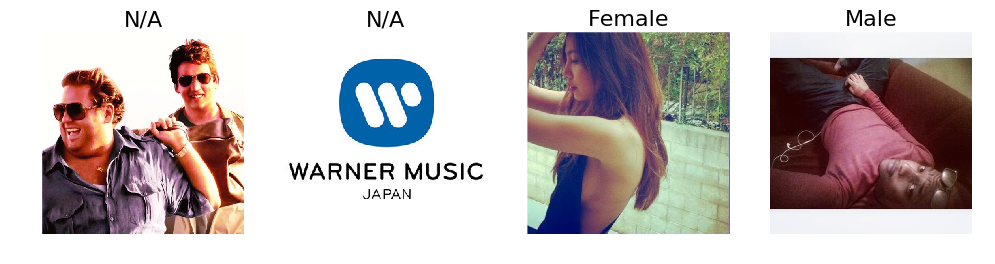

In [96]:
correct = np.where(preds==labels)[0]
idx = np.random.permutation(correct)[:4]
plots_idx(idx, get_titles(preds[idx]))

### Incorrect labels at random

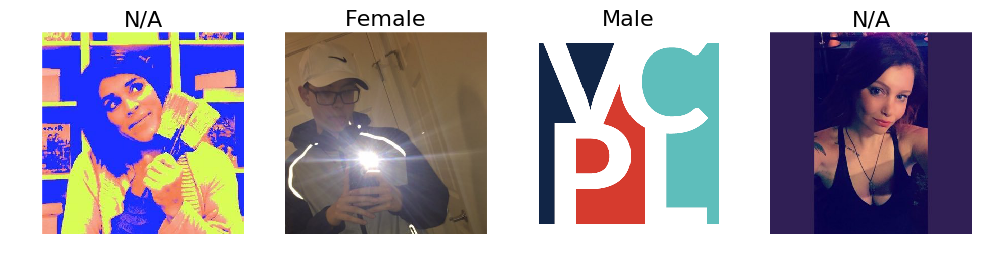

In [97]:
correct = np.where(preds!=labels)[0]
idx = np.random.permutation(correct)[:4]
titles = [all_titles[title] for title in preds[idx]]
plots_idx(idx, titles)

In [98]:
def get_most_correct(label):
    correct = np.where((preds == label) & (preds == labels))[0]
    most_correct = np.argsort(probs[correct][:,label])[::-1][:4]
    plots_idx(correct[most_correct], probs[correct][most_correct])
    
def get_most_incorrect(label):
    incorrect = np.where((preds == label) & (preds != labels))[0]
    most_incorrect = np.argsort(probs[incorrect][:,label])[:4]
    plots_idx(incorrect[most_incorrect], probs[incorrect][most_incorrect])
    
def get_highest_uncertainy(label):
    correct = np.where((preds == label) & (preds == labels))[0]
    most_correct = np.argsort(probs[correct][:,label])[:4]
    plots_idx(correct[most_correct], probs[correct][most_correct])

### Display 4 of the most certain from each category.

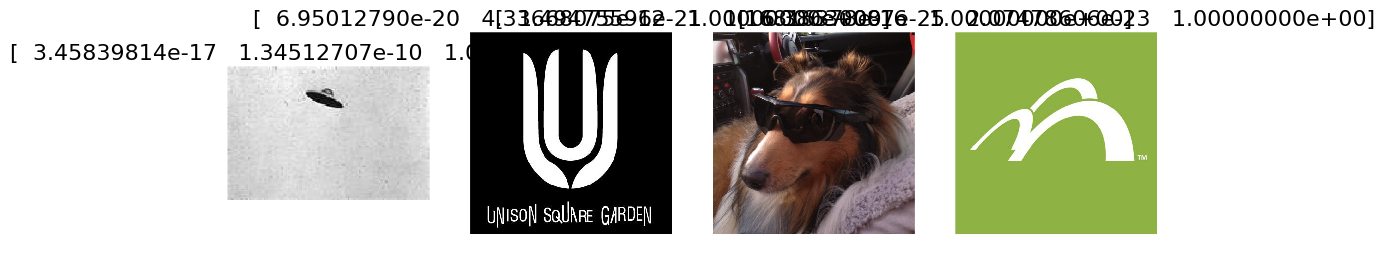

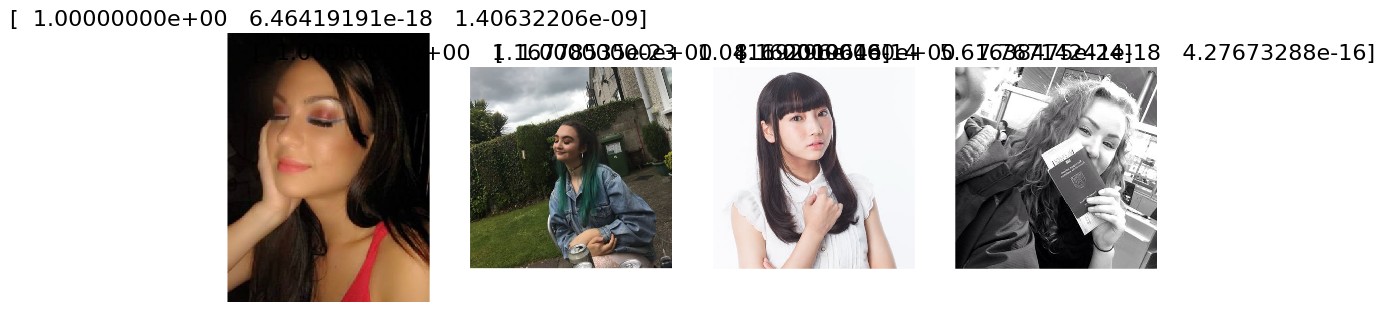

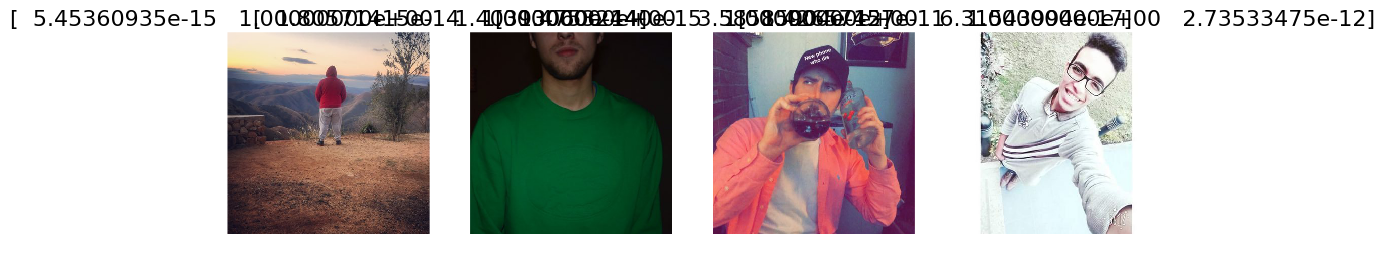

In [99]:
FEMALE = 0; MALE = 1; BRAND = 2

get_most_correct(BRAND)
get_most_correct(FEMALE)
get_most_correct(MALE)

### Display 4 that are incorrect with high probabilities.

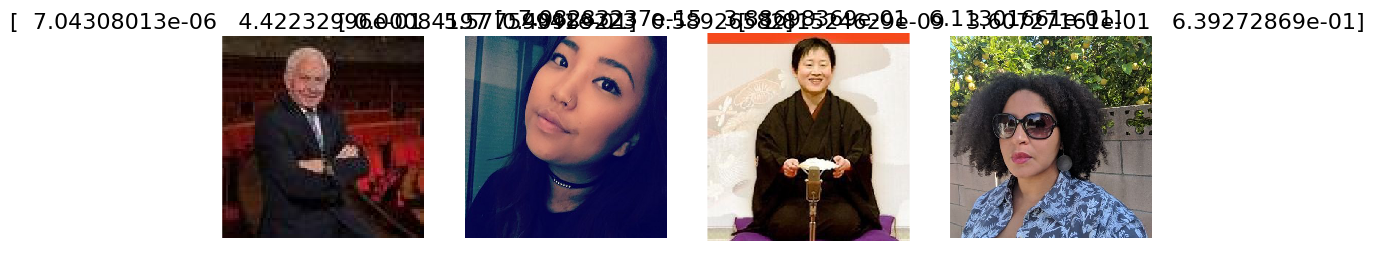

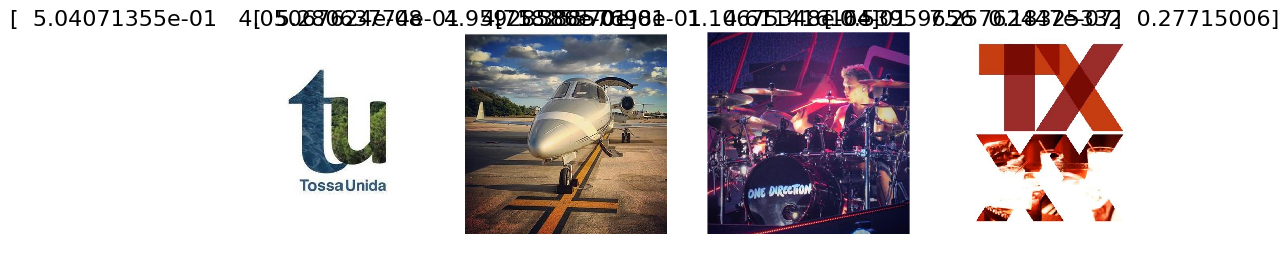

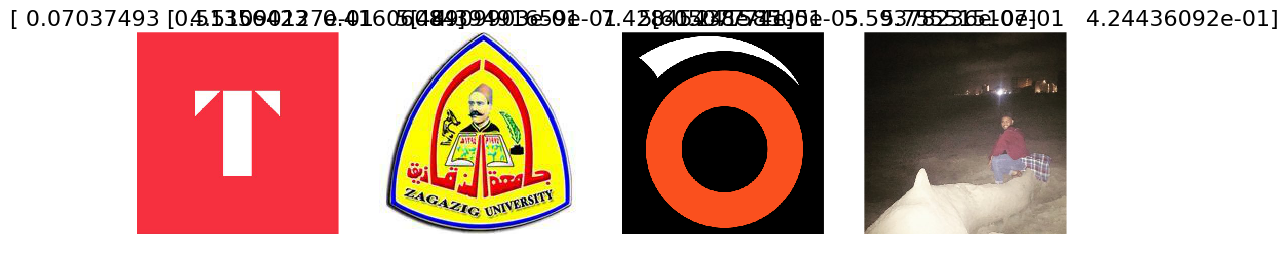

In [100]:
FEMALE = 0; MALE = 1; BRAND = 2

get_most_incorrect(BRAND)
get_most_incorrect(FEMALE)
get_most_incorrect(MALE)

### Highest uncertainy.

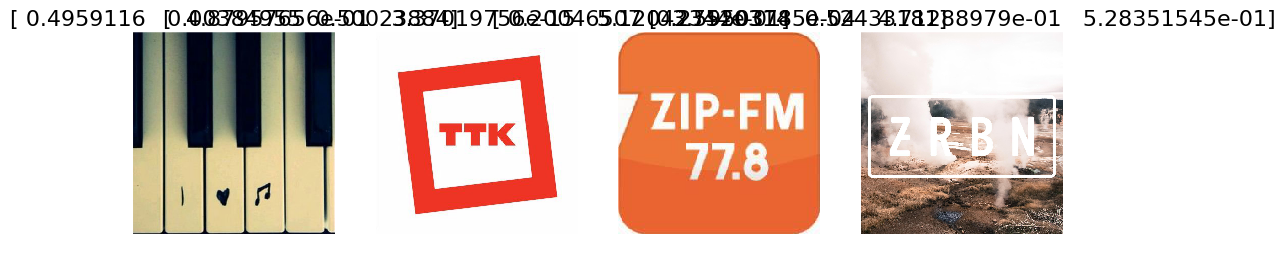

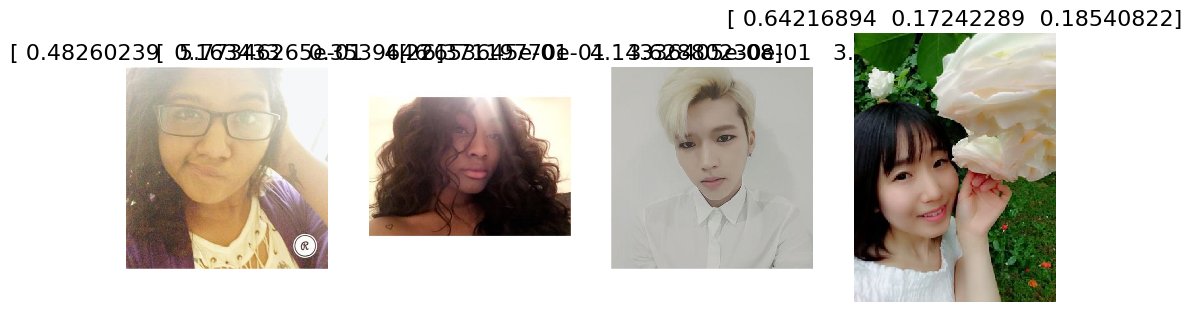

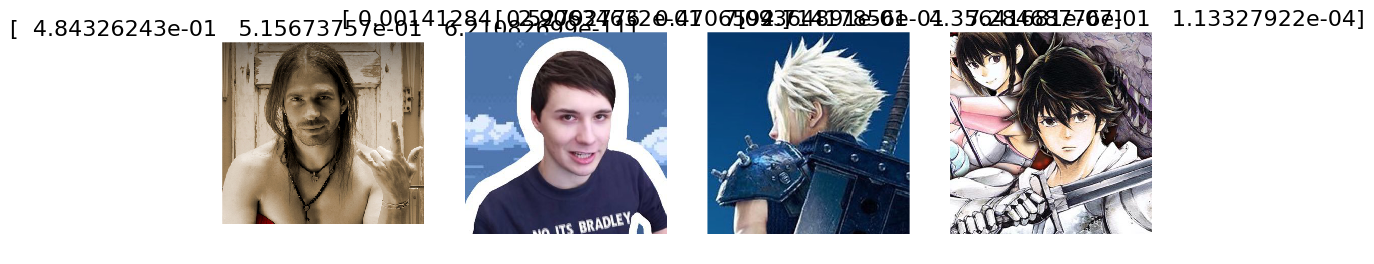

In [101]:
get_highest_uncertainy(BRAND)
get_highest_uncertainy(FEMALE)
get_highest_uncertainy(MALE)

### Attempt to increase performance with data augmentation

In [48]:
from keras.preprocessing.image import ImageDataGenerator

aug_gen = ImageDataGenerator(
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest')

In [ ]:
batches = aug_gen.flow_from_directory(
    data_path + 'male_female_training_set_20170610_cleaned/train', target_size=(224, 224),
    class_mode='categorical', batch_size=4)
val_batches = gen.flow_from_directory(
    data_path + 'male_female_training_set_20170610_cleaned/test', target_size=(224, 224),
    class_mode='categorical', batch_size=4)
model = VGG_16()
model.load_weights(fpath)
model = finetune(model, batches)
model.fit_generator(
    batches, samples_per_epoch=batches.nb_sample,
    nb_epoch=3, validation_data=val_batches,
    nb_val_samples=val_batches.nb_sample)

Found 6450 images belonging to 3 classes.
Found 668 images belonging to 3 classes.
Epoch 1/3
5592/6450 [=========================>....] - ETA: 22s - loss: 1.4077 - acc: 0.4778

So it seems like data augementation actually does worse for this problem? Interesting.